In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,f1_score,precision_score

In [9]:
data = pd.read_csv("all-data.csv",encoding="ISO-8859-1",names=["label","review"])

In [10]:
data.head()

,label,review
0,neutral,"According to Gran , the company has no plans t..."
1,neutral,Technopolis plans to develop in stages an area...
2,negative,The international electronic industry company ...
3,positive,With the new production plant the company woul...
4,positive,According to the company 's updated strategy f...


In [12]:
data.shape

(4846, 2)

In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4846 entries, 0 to 4845
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   4846 non-null   object
 1   review  4846 non-null   object
dtypes: object(2)
memory usage: 75.8+ KB


In [14]:
data.isna().sum()

label     0
review    0
dtype: int64

In [15]:
data["label"].value_counts()

label
neutral     2879
positive    1363
negative     604
Name: count, dtype: int64

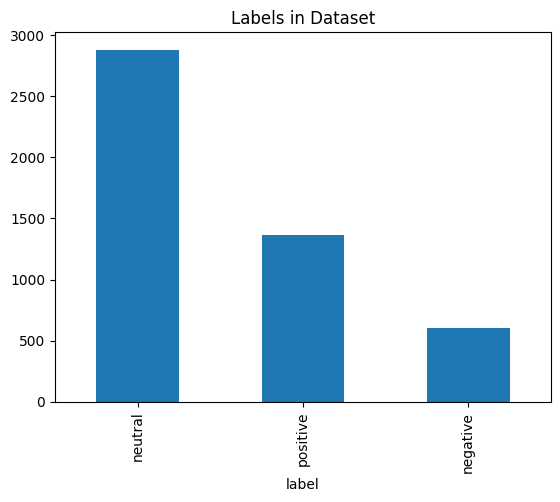

In [20]:
data["label"].value_counts().plot(kind="bar")
plt.title("Labels in Dataset")
plt.show()

In [23]:
data["label"] = data["label"].map({"neutral":2,"positive":1,"negative":0})

In [26]:
data.sample(10)

,label,review
709,1,"Due to rapid expansion , the market share of T..."
1308,2,"Outotec , headquartered in Espoo , Finland , i..."
1222,1,Finnish engineering and technology company Met...
1072,2,Professional and consumer applications include...
4670,0,down to EUR5 .9 m H1 '09 3 August 2009 - Finni...
1571,1,One of the installed elevators will be a doubl...
1866,2,The Engines in Asia-Pacific industry profile i...
2571,2,STOCKMANN plc COMPANY ANNOUNCEMENT February 20...
3897,2,The result before taxes was a loss of 25.0 mil...
3386,2,The transaction was announced on September 29 ...


In [91]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download("stopwords")
nltk.download("wordnet")

sw = stopwords.words("english")
wn = WordNetLemmatizer()


def pre_processing(text):
    text = re.sub(r'\d+', '', text)  # Remove numbers
    text = re.sub(r'[^\w\s]', '', text)
    text = text.lower().split()
    text = " ".join(wn.lemmatize(word) for word in text if word not in sw)
    return text

def main(series):
    if isinstance(series,list):
        series = pd.Series(series)
    return series.astype(str).apply(pre_processing)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hasee\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\hasee\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [31]:
data["review"].apply(pre_processing)

0       according gran , company plan move production ...
1       technopolis plan develop stage area less 100,0...
2       international electronic industry company elco...
3       new production plant company would increase ca...
4       according company 's updated strategy year 200...
                              ...                        
4841    london marketwatch -- share price ended lower ...
4842    rinkuskiai 's beer sale fell 6.5 per cent 4.16...
4843    operating profit fell eur 35.4 mn eur 68.8 mn ...
4844    net sale paper segment decreased eur 221.6 mn ...
4845    sale finland decreased 10.5 % january , sale o...
Name: review, Length: 4846, dtype: object

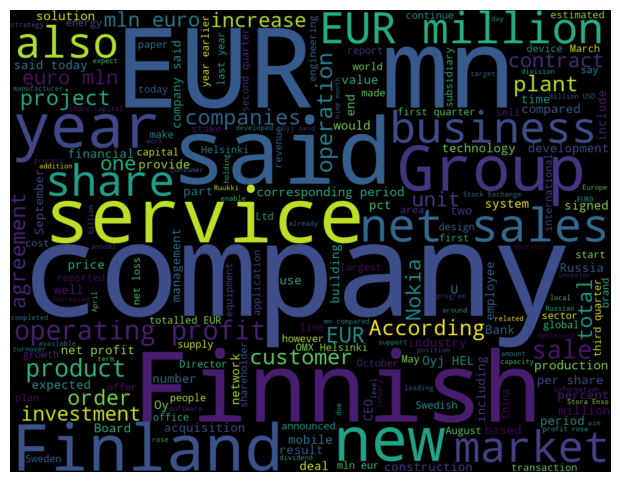

In [92]:
import wordcloud
from wordcloud import WordCloud
sw = stopwords.words("english")

text = " ".join(word for word in data["review"])
wc = WordCloud(width=1300,height=1000,background_color="black",stopwords = sw ).generate(text)

plt.figure(figsize=(14,6))
plt.imshow(wc,interpolation="bilinear")
plt.axis("off")
plt.show()


In [93]:
x=data["review"]
y=data["label"]
x.shape,y.shape

((4846,), (4846,))

In [94]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=42)
x_train.shape,y_train.shape

((3876,), (3876,))

In [138]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn import set_config

In [146]:
pipe = Pipeline([
    ("pre_processing",FunctionTransformer(main)),
    ("vecorization",TfidfVectorizer()),
    ("model",xgb.XGBClassifier(random_state=42))
])
set_config(display="diagram")
pipe

Pipeline(steps=[('pre_processing',
                 FunctionTransformer(func=<function main at 0x00000129A89C18A0>)),
                ('vecorization', TfidfVectorizer()),
                ('model',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feat...ow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=42, ...))])

In [147]:
pipe.fit(x_train,y_train)
y_pred = pipe.predict(x_test)
print("accuracy_score : ",accuracy_score(y_pred,y_test))

accuracy_score :  0.7628865979381443


## CrossVal Score

In [142]:
from sklearn.model_selection import cross_val_score
cross_val_score(pipe,x_train,y_train,cv=5,scoring="accuracy").mean()

0.7381340206185566

# HyperParameter Tunning(logistic regression)

In [121]:
from sklearn.model_selection import GridSearchCV

In [135]:

param_grid = {
    "vecorization__ngram_range": [(1,1), (1,2),(2,2)],  
    "model__C": [0.01,0.001, 0.1, 1, 10],  
    "model__solver": ["liblinear", "saga"],  
    "model__penalty": ["l1", "l2"]  
}


grid = GridSearchCV(pipe,n_jobs=-1,param_grid=param_grid,cv=5,scoring="accuracy")
grid.fit(x_train,y_train)
print(grid.best_params_)
print(grid.best_score_)

{'model__C': 10, 'model__penalty': 'l2', 'model__solver': 'saga', 'vecorization__ngram_range': (1, 2)}
0.7453558363817757
